# Working with Universal Dependencies

The Universal Dependencies framework distributes annotated corpora for many languages, all using the same dependency format. In this notebook, I'll demonstrate how to access such a corpus from within Python. 

We will work with English GUM corpus. You can find it listed under "English" on https://universaldependencies.org/#language- The repository with the actual corpus is at https://github.com/UniversalDependencies/UD_English-GUM/tree/master

From the github repository, please download the training portion of the corpus, and put it in the same directory as this notebook. 

First, we will take a look at the format in which Universal Dependencies corpora are stored.

In [16]:
# if you don't have conllu yet, uncomment the following
!python -m pip install conllu

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import conllu # reading Universal Dependency files in the CONLLu format

We open the GUM corpus as a text file, and look at its first few lines. After the initial metadata, the first sentence starts with the line
      "# text = Aesthetic Appreciation and Spanish Art:"

In [3]:
with open("ko_kaist-ud-train.conllu", encoding="utf-8") as f:
    data = f.read()

In [11]:

def parseconllu():
    sentences = []
    with open("ko_kaist-ud-train.conllu", encoding='utf-8') as fh:
        sent_lines = []
        for raw in fh:
            line = raw.rstrip('\n')
            if line.startswith('#'):
                sent_lines.append(line)
            elif line.strip() == '':
                if sent_lines:
                    sentences.append(sent_lines)
                    sent_lines = []
            else:
                sent_lines.append(line)
        if sent_lines:
            sentences.append(sent_lines)

    parsed = []
    for s in sentences:
        tokens = []
        for ln in s:
            if ln.startswith('#'):
                continue
            parts = ln.split('\t')
            if len(parts) != 10:
                continue
            id_, form, lemma, upos, xpos, feats, head, deprel, deps, misc = parts
            if '-' in id_:
                continue
            try:
                id_int = int(id_)
            except Exception:
                continue
            token = {
                'id': id_int,
                'form': form,
                'lemma': lemma,
                'upos': upos,
                'xpos': xpos,
                'feats': feats,
                'head': int(head) if head != '_' else None,
                'deprel': deprel,
                'deps': deps,
                'misc': misc
            }
            tokens.append(token)
        if tokens:
            tokens.sort(key=lambda t: t['id'])
            parsed.append(tokens)
    return parsed

sents = parseconllu()
print(f'Parsed {len(sents)} sentences')

Parsed 23010 sentences


In [12]:
import pandas as pd
import os
OUT_DIR = 'data/project_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

def parse_conllu(path):
    """
    Return list of sentences; each sentence is a list of token dicts:
    {id:int, form:str, lemma:str, upos:str, head:int or None, deprel:str}
    Ignores multiword lines (1-2) and empty-node decimal ids (3.1).
    """
    sents = []
    tokens = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            if not line:
                if tokens:
                    sents.append(tokens)
                    tokens = []
                continue
            if line.startswith("#"):
                continue
            cols = line.split("\t")
            if len(cols) != 10:
                continue
            id_field = cols[0]
            # skip multiword / empty nodes
            if "-" in id_field or "." in id_field:
                continue
            try:
                tid = int(id_field)
            except ValueError:
                continue
            form = cols[1]
            lemma = cols[2]
            upos = cols[3]
            head = cols[6]
            deprel = cols[7]
            try:
                head_int = int(head) if head != "_" else None
            except ValueError:
                head_int = None
            tok = {"id": tid, "form": form, "lemma": lemma, "upos": upos, "head": head_int, "deprel": deprel}
            tokens.append(tok)
    # final
    if tokens:
        sents.append(tokens)
    return sents

from collections import defaultdict, Counter
verb_instances = 0
obj_instances = 0
obj_immediate = 0
obj_within3 = 0
obj_to_right = 0
dist_counter = Counter()

examples = defaultdict(list) 

for sent_idx, tokens in enumerate(sents):
    id_to_tok = {t['id']: t for t in tokens}
    dependents = defaultdict(list)
    for t in tokens:
        if t['head'] is not None and t['head'] in id_to_tok:
            dependents[t['head']].append(t)
    id_to_index = {t['id']: i for i, t in enumerate(tokens)}

    for i, tok in enumerate(tokens):
        if tok['upos'] == 'VERB':
            verb_instances += 1
            verb_id = tok['id']
            deps = dependents.get(verb_id, [])
            for dep in deps:
                if dep['deprel'] == 'obj':
                    obj_instances += 1
                    obj_idx = id_to_index.get(dep['id'])
                    verb_idx = i
                    if obj_idx is None:
                        continue
                    diff = verb_idx - obj_idx  # positive if object is to verb's left
                    dist_counter[diff] += 1
                    if diff == 1:
                        obj_immediate += 1
                    if 1 <= diff <= 3:
                        obj_within3 += 1
                    if diff < 0:
                        obj_to_right += 1

                    
                    lemma = tok['lemma'] if tok['lemma'] != '_' else tok['form']
                    if len(examples[lemma]) < 5:
                        sent_form = ' '.join([t['form'] for t in tokens])
                        examples[lemma].append((dep['form'], tok['form'], sent_form))

if obj_instances > 0:
    pct_immediate = obj_immediate / obj_instances * 100
    pct_within3 = obj_within3 / obj_instances * 100
    pct_after = obj_to_right / obj_instances * 100
else:
    pct_immediate = pct_within3 = 0.0

print('Verb instances (VERB tokens):', verb_instances)
print('Total obj instances:', obj_instances)
print(f'Objects immediately before verb: {obj_immediate} ({pct_immediate:.2f}%)')
print(f'Objects within 3 before verb: {obj_within3} ({pct_within3:.2f}%)')
print(f'Objects after verb: {obj_to_right} ({pct_after:.2f}%)')

dist_items = sorted(dist_counter.items())
df_dist = pd.DataFrame(dist_items, columns=['verb_minus_obj_index', 'count'])
df_dist.to_csv(os.path.join(OUT_DIR, 'object_verb_distance_distribution.csv'), index=False)
print('Saved distance distribution to', os.path.join(OUT_DIR, 'object_verb_distance_distribution.csv'))


Verb instances (VERB tokens): 55805
Total obj instances: 13912
Objects immediately before verb: 10066 (72.35%)
Objects within 3 before verb: 12937 (92.99%)
Objects after verb: 0 (0.00%)
Saved distance distribution to data/project_outputs\object_verb_distance_distribution.csv


In [ ]:

import os
from collections import defaultdict, Counter
import json
import numpy as np
import pandas as pd

CONLLU_PATH = "ko_kaist-ud-train.conllu"   #Just a reminder, all files are directly just in the same folder as this code.
OUT_DIR = "data/project_outputs_task2"
os.makedirs(OUT_DIR, exist_ok=True)

VERB_UPOS = ("VERB", "AUX")   # token UPOS considered verbs
COPULA_CANONICAL = "이"       # canonical token for copula (이)

def parse_conllu(path): #Nothing much here, same as previous parse functions, just has a path argument now
    sents = []
    tokens = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            if not line:
                if tokens:
                    sents.append(tokens)
                    tokens = []
                continue
            if line.startswith("#"):
                continue
            cols = line.split("\t")
            if len(cols) != 10:
                continue
            id_field = cols[0]
            if "-" in id_field or "." in id_field:
                
                continue
            try:
                tid = int(id_field)
            except ValueError:
                continue
            form = cols[1]
            lemma = cols[2]
            upos = cols[3]
            head = cols[6]
            deprel = cols[7]
            try:
                head_int = int(head) if head != "_" else None
            except ValueError:
                head_int = None
            tok = {
                "id": tid,
                "form": form,
                "lemma": lemma,
                "upos": upos,
                "head": head_int,
                "deprel": deprel
            }
            tokens.append(tok)
    if tokens:
        sents.append(tokens)
    return sents

import re

def normalize_korean_verb(lemma_or_form):

    if not lemma_or_form or lemma_or_form == "_":
        return lemma_or_form

    
    s = lemma_or_form.replace("＋", "+").replace("‧", "+").strip()

    #if segmented with '+', split into morphemes
    if "+" in s:
        parts = [p for p in s.split("+") if p]  # drop empty parts
        #if any part equals the copula morpheme '이', treat as copula
        if any(p == "이" for p in parts):
            return COPULA_CANONICAL
        return parts[0]

    #if unsegmented but ends with '다', strip terminal '다' 
    if len(s) > 1 and s.endswith("다"):
        return s[:-1]

    return s

# ensures counts/locations are collapsed to normalized keys
def aggregate_normalized_counts(counter, locations):

    norm_counter = Counter()
    norm_locations = defaultdict(list)
    if locations:
        for raw_key, locs in locations.items():
            norm = normalize_korean_verb(raw_key)
            norm_counter[norm] += len(locs)
            norm_locations[norm].extend(locs)
    else:
        for raw_key, cnt in counter.items():
            norm = normalize_korean_verb(raw_key)
            norm_counter[norm] += cnt
    return norm_counter, norm_locations



def verb_frequencies(sents, verb_upos=VERB_UPOS):
    counter = Counter()
    locations = defaultdict(list)  # canonical_verb -> list of (sent_idx, token_idx, original_token)
    for si, tokens in enumerate(sents):
        for i, tok in enumerate(tokens):
            if tok["upos"] in verb_upos:
                lemma = tok["lemma"] if tok["lemma"] != "_" else tok["form"]
                norm = normalize_korean_verb(lemma)
                counter[norm] += 1
                locations[norm].append((si, i, tok))
    return counter, locations


def select_verbs_by_quantiles(counter, top_pct=0.20, next_pct=0.20, top_k_each=20):
    items = counter.most_common()
    types = [v for v, _ in items]
    n_types = len(types)
    top_n_types = max(1, int(n_types * top_pct))
    next_n_types = max(1, int(n_types * next_pct))
    top_type_set = set(types[:top_n_types])
    next_type_set = set(types[top_n_types: top_n_types + next_n_types])
    top_candidates = [v for v, _ in items if v in top_type_set]
    next_candidates = [v for v, _ in items if v in next_type_set]
    return top_candidates[:top_k_each], next_candidates[:top_k_each]


def extract_verb_sets(sents, verb_locations, verbs, 
                      subj_deprels=("nsubj", "nsubj:pass", "csubj"), 
                      obj_deprels_prefix=("obj",), 
                      modifier_deprels_prefixes=("advmod", "amod", "nmod", "obl", "advcl", "compound")):
    results = {}
    for verb in verbs:
        subj_c = Counter()
        obj_c = Counter()
        mod_c = Counter()
        before_c = Counter()
        after_c = Counter()
        occ = 0
        locs = verb_locations.get(verb, [])
        for si, vi, original_tok in locs:
            sent = sents[si]
            if vi < 0 or vi >= len(sent):
                continue
            occ += 1
            id_to_tok = {t['id']: t for t in sent}
            dependents = defaultdict(list)
            for t in sent:
                h = t['head']
                if h is not None and h in id_to_tok:
                    dependents[h].append(t)
            v_deps = dependents.get(original_tok['id'], [])
            for dep in v_deps:
                deprel = dep['deprel']
                if deprel in subj_deprels or deprel.startswith("nsubj"):
                    head_form = dep['lemma'] if dep['lemma'] != "_" else dep['form']
                    subj_c[head_form] += 1
                if any(deprel == p or deprel.startswith(p) for p in obj_deprels_prefix):
                    head_form = dep['lemma'] if dep['lemma'] != "_" else dep['form']
                    obj_c[head_form] += 1
                if any(deprel == p or deprel.startswith(p) for p in modifier_deprels_prefixes):
                    head_form = dep['lemma'] if dep['lemma'] != "_" else dep['form']
                    mod_c[head_form] += 1
            if vi - 1 >= 0:
                before_c[sent[vi-1]['form']] += 1
            if vi + 1 < len(sent):
                after_c[sent[vi+1]['form']] += 1
        results[verb] = {
            "subject": subj_c,
            "object": obj_c,
            "modifier": mod_c,
            "before": before_c,
            "after": after_c,
            "occurrences": occ
        }
    return results

def load_korean_vector_model(bin_path=None, tsv_path=None, verbose=True):
    
    
    from gensim.models import KeyedVectors, Word2Vec
    attempts = []
    
    def _log(msg):
        if verbose:
            print(msg)
    """
    if bin_path and os.path.exists(bin_path):
        try:
            _log(f"Trying Word2Vec.load on {bin_path} ...")
            model = Word2Vec.load(bin_path)
            if hasattr(model, 'wv'):
                _log("Loaded Word2Vec; returning model.wv")
                return model.wv
            if isinstance(model, KeyedVectors) or hasattr(model, 'key_to_index'):
                _log("Loaded object looks like KeyedVectors; returning it directly.")
                return model
            if hasattr(model, 'vectors') and hasattr(model, 'index_to_key'):
                kv = KeyedVectors(vector_size=model.vector_size if hasattr(model,'vector_size') else model.vectors.shape[1])
                kv.add_vectors(model.index_to_key, model.vectors)
                _log("Converted loaded object to KeyedVectors and returning.")
                return kv
            attempts.append(("Word2Vec.load_unexpected_type", f"Loaded type {type(model)} lacked expected attributes"))
        except Exception as e:
            attempts.append(("Word2Vec.load", str(e)))

    if bin_path and os.path.exists(bin_path):
        try:
            _log(f"Trying KeyedVectors.load on {bin_path} ...")
            kv = KeyedVectors.load(bin_path, mmap='r')
            _log("Loaded KeyedVectors via KeyedVectors.load()")
            return kv
        except Exception as e:
            attempts.append(("KeyedVectors.load", str(e)))

    if bin_path and os.path.exists(bin_path):
        try:
            _log(f"Trying gensim.models.fasttext.load_facebook_model on {bin_path} ...")
            from gensim.models.fasttext import load_facebook_model
            ft = load_facebook_model(bin_path)
            _log("Loaded fastText (facebook) model; returning ft.wv")
            return ft.wv
        except Exception as e:
            attempts.append(("fasttext_fb", str(e)))

    
    if bin_path and os.path.exists(bin_path):
        try:
            _log("Trying python-fasttext (fasttext) to load .bin (supervised or unsupervised)...")
            import fasttext
            ftmodel = fasttext.load_model(bin_path)  
            words = ftmodel.get_words()
            
            vectors = []
            found_words = []
            for w in words:
                vec = ftmodel.get_word_vector(w)
                if vec is None:
                    continue
                found_words.append(w)
                vectors.append(np.array(vec, dtype=np.float32))
            if not vectors:
                raise RuntimeError("fasttext loaded but no word vectors returned.")
            vecs_arr = np.vstack(vectors)
            kv = KeyedVectors(vector_size=vecs_arr.shape[1])
            kv.add_vectors(found_words, vecs_arr)
            _log("Constructed KeyedVectors from python-fasttext model; returning.")
            return kv
        except Exception as e:
            attempts.append(("fasttext_py", str(e)))

    
    if bin_path and os.path.exists(bin_path):
        try:
            _log(f"Trying KeyedVectors.load_word2vec_format(binary=True) on {bin_path} ...")
            kv = KeyedVectors.load_word2vec_format(bin_path, binary=True, unicode_errors='ignore')
            _log("Loaded KeyedVectors from word2vec binary.")
            return kv
        except Exception as e:
            attempts.append(("w2v_binary", str(e)))"""

    # Tried multiple ways to load the word2vec model but it was acting super weird and the stackoverflow page got very confusing for me
    # (https://stackoverflow.com/questions/70458726/cant-load-the-pre-trained-word2vec-of-korean-language)
    # Now I am just manually loading the whole model, let me know if you think this is the correct way
    if tsv_path and os.path.exists(tsv_path):
        try:
            _log(f"Inspecting text vector file {tsv_path} ...")
            with open(tsv_path, 'r', encoding='utf-8', errors='ignore') as f:
                
                sample = []
                max_lines = 5000  
                for i, line in enumerate(f):
                    if not line.strip():
                        continue
                    sample.append(line.rstrip('\n'))
                    if i >= max_lines:
                        break
            if not sample:
                raise RuntimeError("Text vector file appears empty or unreadable.")
            
            first_tokens = sample[0].strip().split()
            header_like = False
            if len(first_tokens) >= 2 and first_tokens[0].isdigit() and first_tokens[1].isdigit():
                header_like = True

            

            _log("No headers so parsing text file line-by-line and building KeyedVectors (this may take time on your computers).")
            words = []
            vecs = []
            dim = None
            with open(tsv_path, 'r', encoding='utf-8', errors='ignore') as fh:
                for line in fh:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) < 2:
                        # malformed; skip
                        continue
                    word = parts[0]
                    num_tokens = parts[1:]
                    # try convert to floats
                    try:
                        vec = np.array([float(x) for x in num_tokens], dtype=np.float32)
                    except Exception:
                        # kip line with non-numeric tokens
                        continue
                    if dim is None:
                        dim = vec.shape[0]
                    else:
                        # if vector dims mismatch, skip
                        if vec.shape[0] != dim:
                            continue
                    words.append(word)
                    vecs.append(vec)
            if not words:
                raise RuntimeError("No valid word/vector lines parsed from file.")
            arr = np.vstack(vecs)
            kv = KeyedVectors(vector_size=arr.shape[1])
            kv.add_vectors(words, arr)
            _log(f"Constructed KeyedVectors from text file with {len(words)} words and dim {arr.shape[1]}.")
            return kv
        except Exception as e:
            attempts.append(("w2v_text_manual", str(e)))


def centroid_of_words(model, words):
    vecs = []
    missed = []
    for w in words:
        if w is None:
            continue
        key = w
        # for Korean we might want to try forms and lemmas as separate keys present assumption is that keys are surface tokens
        if key in model:
            vecs.append(model[key])
        else:
            missed.append(w)
    if not vecs:
        return None, 0, missed
    arr = np.vstack(vecs)
    return np.mean(arr, axis=0), arr.shape[0], missed

def topk_neighbors_from_centroid(model, centroid_vec, k=10):
    if centroid_vec is None:
        return []
    return model.similar_by_vector(centroid_vec, topn=k)


def build_task2_analysis(conllu_path=CONLLU_PATH, model_bin=None, model_tsv=None, k_neighbors=10, top_k_each=5):
    sents = parse_conllu(conllu_path)
    print(f"Loaded {len(sents)} sentences from {conllu_path}")
    raw_counter, raw_locations = verb_frequencies(sents)

    verb_counter, verb_locations = aggregate_normalized_counts(raw_counter, raw_locations)

    vf_df = pd.DataFrame(verb_counter.most_common(), columns=["verb_norm", "freq"])
    
    vf_df.to_csv(os.path.join(OUT_DIR, "verb_frequencies_normalized.csv"), index=False, encoding="utf-8-sig")
    top_verbs, mid_verbs = select_verbs_by_quantiles(verb_counter, top_pct=0.20, next_pct=0.20, top_k_each=top_k_each)
    print("Top verbs (sample):", top_verbs)
    print("Mid verbs (sample):", mid_verbs)
    verbs_to_analyze = list(top_verbs) + list(mid_verbs)
    sets = extract_verb_sets(sents, verb_locations, verbs_to_analyze)
    summary = {}
    for v in verbs_to_analyze:
        entry = sets[v]
        summary[v] = {
            "occurrences": entry["occurrences"],
            "top_subjects": entry["subject"].most_common(50),
            "top_objects": entry["object"].most_common(50),
            "top_modifiers": entry["modifier"].most_common(50),
            "top_before": entry["before"].most_common(50),
            "top_after": entry["after"].most_common(50)
        }
    with open(os.path.join(OUT_DIR, "verb_sets_summary_normalized.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    model = None
    neighbors_summary = {}
    if (model_bin and os.path.exists(model_bin)) or (model_tsv and os.path.exists(model_tsv)):
        print("Attempting to load vector model...")
        model = load_korean_vector_model(bin_path=model_bin, tsv_path=model_tsv)
        print("Computing centroids and nearest neighbors...")
        for v in verbs_to_analyze:
            neighbors_summary[v] = {}
            for set_name in ("top_subjects", "top_objects", "top_modifiers", "top_before", "top_after"):
                words = [w for w, cnt in summary[v][set_name][:200]]
                centroid, n_in_vocab, missed = centroid_of_words(model, words)
                knn = topk_neighbors_from_centroid(model, centroid, k=k_neighbors) if centroid is not None else []
                neighbors_summary[v][set_name] = {
                    "centroid_n_in_vocab": int(n_in_vocab),
                    "missed_count": len(missed),
                    "missed_examples": missed[:30],
                    "knn": [(w, float(sim)) for w, sim in knn]
                }
        with open(os.path.join(OUT_DIR, "verb_neighbors_summary_normalized.json"), "w", encoding="utf-8") as f:
            json.dump(neighbors_summary, f, ensure_ascii=False, indent=2)
    else:
        print("No model files provided or found; skipping centroid/knn stage.")

    return {
        "sentences": len(sents),
        "verb_freq_df": vf_df,
        "top_verbs": top_verbs,
        "mid_verbs": mid_verbs,
        "sets": sets,
        "summary": summary,
        "neighbors_summary": neighbors_summary if model else None
    }


res = build_task2_analysis(
    conllu_path="ko_kaist-ud-train.conllu",
    model_bin="ko.bin",     
    model_tsv="ko.tsv",     
    k_neighbors=20,
    top_k_each=20
)



Loaded 23010 sentences from ko_kaist-ud-train.conllu
Top verbs (sample): ['이', '하', '있', '되', '않', '보', '이러하', '대하', '주', '알', '보이', '생각', '가지', '말하', '못하', '오', '만들', '살', '받', '이루']
Mid verbs (sample): ['물리치', '민감', '내려오', '제창', '갈', '문지르', '벗기', '자르', '되돌리', '담그', '금하', '대신', '낫', '운동', '공개', '소멸', '상호', '이바지', '낭비', '거절']
Attempting to load vector model...
Inspecting text vector file ko.tsv ...
No headers so parsing text file line-by-line and building KeyedVectors (this may take time on your computers).
Constructed KeyedVectors from text file with 603232 words and dim 5.
Computing centroids and nearest neighbors...


In [ ]:
adj_after_adjacent = 0    
adj_within3_after = 0    
adj_syntactic_amod = 0   

for i, tok in enumerate(tokens):
    if tok['upos'] == 'VERB':
        verb_idx = i
        verb_id = tok['id']
        deps = dependents.get(verb_id, [])
        for dep in deps:
            if dep['deprel'] == 'obj':
                obj_idx = id_to_index.get(dep['id'])
                
                for k in range(1, 4):  
                    check_idx = obj_idx + k
                    if check_idx < len(tokens):
                        nxt = tokens[check_idx]
                        if nxt['upos'] == 'ADJ':
                            if k == 1:
                                adj_after_adjacent += 1
                            adj_within3_after += 1
                obj_id = dep['id']
                obj_dependents = dependents.get(obj_id, [])
                for od in obj_dependents:
                    if od['deprel'] == 'amod' or od['upos'] == 'ADJ':
                        adj_syntactic_amod += 1




In [15]:

from collections import defaultdict

verb_obj_counts = defaultdict(int)
verb_obj_immediate = defaultdict(int)

for sent_idx, tokens in enumerate(sents):
    id_to_tok = {t['id']: t for t in tokens}
    dependents = defaultdict(list)
    for t in tokens:
        if t['head'] is not None and t['head'] in id_to_tok:
            dependents[t['head']].append(t)
    id_to_index = {t['id']: i for i, t in enumerate(tokens)}

    for i, tok in enumerate(tokens):
        if tok['upos'] == 'VERB':
            verb_id = tok['id']
            lemma = tok['lemma'] if tok['lemma'] != '_' else tok['form']
            deps = dependents.get(verb_id, [])
            for dep in deps:
                if dep['deprel'] == 'obj':
                    verb_obj_counts[lemma] += 1
                    obj_idx = id_to_index.get(dep['id'])
                    if obj_idx is not None and i - obj_idx == 1:
                        verb_obj_immediate[lemma] += 1

rows = []
for lemma, cnt in verb_obj_counts.items():
    rows.append({
        'lemma': lemma,
        'obj_count': cnt,
        'obj_immediate_count': verb_obj_immediate.get(lemma, 0),
        'pct_immediate': verb_obj_immediate.get(lemma, 0) / cnt * 100 if cnt>0 else 0
    })
df_verb_obj = pd.DataFrame(rows).sort_values('obj_count', ascending=False)

display(df_verb_obj.head(20))
csv_path = os.path.join(OUT_DIR, 'verbs_with_obj_stats.csv')
df_verb_obj.to_csv(csv_path, index=False)
print('Saved per-verb obj stats to', csv_path)


,lemma,obj_count,obj_immediate_count,pct_immediate
93,하+는,122,59,48.360656
388,가지+고,113,98,86.725664
284,위하+ㄴ,98,90,91.836735
88,하+ㄴ,89,38,42.696629
48,알+ㄹ,84,49,58.333333
386,하+었+다,82,44,53.658537
7,가지+ㄴ,77,68,88.311688
693,하+ㄹ,68,37,54.411765
79,하+ㄴ다,61,27,44.262295
46,지니+고,58,48,82.758621


Saved per-verb obj stats to data/project_outputs\verbs_with_obj_stats.csv


Saved plot to data/project_outputs\object_verb_distance_hist.png


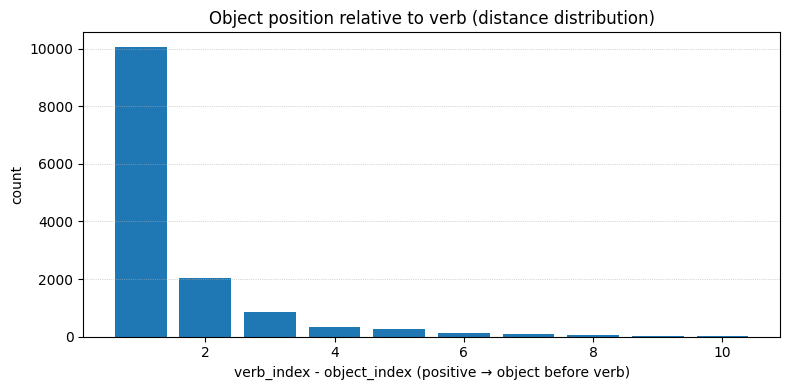

In [8]:

import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(os.path.join(OUT_DIR, 'object_verb_distance_distribution.csv'))

mask = (df['verb_minus_obj_index'] >= -10) & (df['verb_minus_obj_index'] <= 10)
df_vis = df[mask]

plt.figure(figsize=(8,4))
plt.bar(df_vis['verb_minus_obj_index'], df_vis['count'])
plt.xlabel('verb_index - object_index (positive → object before verb)')
plt.ylabel('count')
plt.title('Object position relative to verb (distance distribution)')
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'object_verb_distance_hist.png'))
print('Saved plot to', os.path.join(OUT_DIR, 'object_verb_distance_hist.png'))
plt.show()


In [9]:

for lemma, exs in list(examples.items())[:10]:
    print('LEMMA:', lemma)
    for obj_form, verb_form, sent in exs:
        print('  obj=', obj_form, 'verb=', verb_form)
        print('   ', sent)
    print()


LEMMA: 부리+지
  obj= 탐욕을 verb= 부리지
    뭇 짐승들은 일단 배만 부르면 더 이상의 탐욕을 부리지 않는다 .
  obj= 억지를 verb= 부리지
    네가 맞으면 억지를 부리지 않아도 될 것이고 , 틀리면 아무리 억지를 써도 결국 잘못된 것이기 때문이다 .

LEMMA: 본받+으려
  obj= 인간형을 verb= 본받으려
    이렇게 되면 이러한 인간형을 다투어 본받으려 할 것이 틀림없다 .

LEMMA: 넓히+어
  obj= 시각을 verb= 넓혀
    이제 우리는 개인의 도덕적 차원을 넘어서 우리 사회구성원 전체의 구조적인 의식면으로 시각을 넓혀 볼 때가 되었다 .

LEMMA: 젓+어+가+ㄹ
  obj= 노를 verb= 저어갈
    이것이 구체적으로 눈 앞에 그려져야 우리 모두가 신바람이 나서 힘껏 노를 저어갈 수 있겠기 때문이다 .

LEMMA: 잃+ㄴ
  obj= 믿음을 verb= 잃은
    믿음을 잃은 것이다 .
  obj= 생기를 verb= 잃은
    거무스레하고 칙칙한 피부 , 거칠어진 피부 , 생기를 잃은 피부에 효과적이다 .
  obj= 기운을 verb= 잃은
    길에서 잠시 인터뷰한 십여 명의 라마승들의 말과 인상으로 볼 때 그들은 이미 신앙 종교적 지도자로서 기운을 잃은 것 같았다 .
  obj= 품위를 verb= 잃은
    그리하여 정권을 유지하는 일 , 돈을 버는 일 , 출세를 하는 일 , 심지어는 자녀의 교육에 이르기까지 품위를 잃은 경쟁을 일삼아 왔다 .
  obj= 목표를 verb= 잃은
    좀 더 솔직히 말한다면 경쟁을 위한 경쟁 , 목표를 잃은 경쟁을 해온 것이다 .

LEMMA: 바꾸+어야
  obj= 시각을 verb= 바꿔야
    그러기 위해서는 모든 시각을 근시로부터 원시로 바꿔야 한다 .
  obj= 설계를 verb= 바꾸어야
    무엇보다도 조사연구의 설계를 총체적으로 바꾸어야 한다 .
  obj= 당헌을 verb= 바꾸어야
    지구당원들이 스스로 입후보자를 선출하는

In [2]:
print(data[:4000])

# sent_id = M2TA_064-s1
# text = 하기야 짐승도 잘 가르치기만 하면 어느 정도는 순치될 수 있다.
# translit = .ha.gi.ya .jim.seung.do .jal .ga.reu.chi.gi.man .ha.myeon .eo.neu .jeong.do.neun .sun.chi.doel .su .iss.da.
1	하기야	하기야	CCONJ	maj	_	8	cc	_	Translit=.ha.gi.ya|LTranslit=.ha.gi.ya
2	짐승도	짐승+도	ADV	ncn+jxc	_	8	advcl	_	Translit=.jim.seung.do|LTranslit=.jim.seung+.do
3	잘	잘	ADV	mag	_	4	advmod	_	Translit=.jal|LTranslit=.jal
4	가르치기만	가르치+기+만	ADV	pvg+etn+jxc	_	5	advcl	_	Translit=.ga.reu.chi.gi.man|LTranslit=.ga.reu.chi+.gi+.man
5	하면	하+면	SCONJ	pvg+ecs	_	8	ccomp	_	Translit=.ha.myeon|LTranslit=.ha+.myeon
6	어느	어느	DET	mmd	_	7	det	_	Translit=.eo.neu|LTranslit=.eo.neu
7	정도는	정도+는	NOUN	ncn+jxt	_	8	dislocated	_	Translit=.jeong.do.neun|LTranslit=.jeong.do+.neun
8	순치될	순치+되+ㄹ	VERB	ncpa+xsv+etm	_	0	root	_	Translit=.sun.chi.doel|LTranslit=.sun.chi+.doe+ㄹ
9	수	수	NOUN	nbn	_	8	obl	_	OrigDeprel=aux|Translit=.su|LTranslit=.su
10	있다	있+다	ADJ	paa+ef	_	9	fixed	_	SpaceAfter=No|Translit=.iss.da|LTranslit=.iss+.da
11	.	.	PUNCT	sf	_	9	punct	_	Tran

As you can see, this is a tabular format. There is a line for each word in the sentence, and the information for that word is given in tab-delimited cells, for example:

```2	Appreciation	appreciation	NOUN	NN	Number=Sing	0	root	0:root	Entity=1)|MSeg=Appreciat-ion```

This is the CoNLL-U format, which originated with a shared task at the Conference on Natural Language Learning (CoNLL). 

There is a Python package, conllu, that is made for reading CoNLL-U data. Once we have read the GUM corpus into a string, we can parse it with conllu:

In [5]:
sentences = conllu.parse(data)

The content of `sentences` is a sequence of TokenList objects. Here is the one for the 10th sentence of the corpus:

In [6]:
print(sentences[10])

TokenList<भोजपुरी, खातिर, एगो, बड़हन, आन्दोलन, चलवला, के, जरूरत, :, सदानन्द, शाही, विश्व, भोजपुरी, सम्मेलन, के, बलिया, इकाई, अउर, पाती, सांस्कृतिक, मंच, के, एगो, बड़हन, आयोजन, पिछला, अतवारा, का, दिने, बलिया, के, टाउन, हाल, बापू, भवन, में, भइल, ।, metadata={sent_id: "f1-11", text: "भोजपुरी खातिर एगो बड़हन आन्दोलन चलवला के जरूरत : सदानन्द शाही विश्व भोजपुरी सम्मेलन के बलिया इकाई अउर पाती सांस्कृतिक मंच के एगो बड़हन आयोजन पिछला अतवारा का दिने बलिया के टाउन हाल बापू भवन में भइल ।", translit: "bhojapurī khātira ego baṛahana āndolana calavalā ke jarūrata : sadānanda śāhī viśva bhojapurī sammelana ke baliyā ikāī aura pātī sāṁskr̥tika maṁca ke ego baṛahana āyojana pichalā atavārā kā dine baliyā ke ṭāuna hāla bāpū bhavana meṁ bhaila ."}>


We can access the entries on the TokenList through a for-loop, or using an index. Here is the first token of sentence 10. As you can see, it is a Python dictionary.

In [7]:
sentence10 = sentences[10]
firstword = sentence10[0]
firstword

{'id': 1,
 'form': 'भोजपुरी',
 'lemma': 'भोजपुरी',
 'upos': 'PROPN',
 'xpos': 'N_NNP',
 'feats': {'Case': 'Nom', 'Gender': 'Fem', 'Number': 'Sing', 'Person': '3'},
 'head': 5,
 'deprel': 'compound',
 'deps': None,
 'misc': {'Translit': 'bhojapurī', 'LTranslit': 'bhojapurī'}}

You can access the entries in that dictionary by their keys:

In [8]:
firstword["lemma"]

'भोजपुरी'

To better understand this big dictionary, it helps to view it as an attribute-value matrix. Here is the first word of the 10th sentence of the UD_English-GUM corpus:

In [9]:
firstword = {'id': 1,
  'form': 'Thus',
  'lemma': 'thus',
  'upos': 'ADV',
  'xpos': 'RB',
  'feats': None,
  'head': 16,
  'deprel': 'advmod',
  'deps': None,
  'misc': {'SpaceAfter': 'No'}}

This is the following attribute-value matrix (AVM):

$$
\left[\begin{array}{ll}
\text{id:} & 1\\
\text{form:} & 'Thus'\\
\text{lemma:} & 'thus'\\
\text{upos:} &  'ADV'\\
\text{xpos:} & 'RB'\\
\text{feats:} &  None\\
\text{head:} & 16\\
\text{deprel:}  & advmod\\
\text{deps:}  & None\\
\text{misc:} & \left[\begin{array}{ll}
\text{SpaceAfter:} & 'No'
\end{array}\right]
\end{array}\right]
$$

As you saw above, you can access an entry in this attribute-value matrix through its dictionary key:

In [10]:
firstword["lemma"]

'thus'

One of the values in the AVM is itself an AVM. To access the value that tells you whether there is a space after the word, you need to specify the whole path of keys. `firstword["misc"]` accesses a dictionary, namely `{'SpaceAfter': 'No'}`, which again has keys, in particular `SpaceAfter`: 

In [11]:
firstword["misc"]["SpaceAfter"]

'No'

The Universal Dependencies representation of a whole sentence is a list of tokens, that is, a list of dictionaries (=AVMs):

In [12]:
sentence10 = [{'id': 1,
  'form': 'Thus',
  'lemma': 'thus',
  'upos': 'ADV',
  'xpos': 'RB',
  'feats': None,
  'head': 16,
  'deprel': 'advmod',
  'deps': None,
  'misc': {'SpaceAfter': 'No'}},
 {'id': 2,
  'form': ',',
  'lemma': ',',
  'upos': 'PUNCT',
  'xpos': ',',
  'feats': None,
  'head': 1,
  'deprel': 'punct',
  'deps': None,
  'misc': None},
 {'id': 3,
  'form': 'the',
  'lemma': 'the',
  'upos': 'DET',
  'xpos': 'DT',
  'feats': {'Definite': 'Def', 'PronType': 'Art'},
  'head': 4,
  'deprel': 'det',
  'deps': None,
  'misc': None},
 {'id': 4,
  'form': 'time',
  'lemma': 'time',
  'upos': 'NOUN',
  'xpos': 'NN',
  'feats': {'Number': 'Sing'},
  'head': 16,
  'deprel': 'nsubj',
  'deps': None,
  'misc': None},
 {'id': 5,
  'form': 'it',
  'lemma': 'it',
  'upos': 'PRON',
  'xpos': 'PRP',
  'feats': {'Case': 'Nom',
   'Gender': 'Neut',
   'Number': 'Sing',
   'Person': '3',
   'PronType': 'Prs'},
  'head': 6,
  'deprel': 'nsubj',
  'deps': None,
  'misc': None},
 {'id': 6,
  'form': 'takes',
  'lemma': 'take',
  'upos': 'VERB',
  'xpos': 'VBZ',
  'feats': {'Mood': 'Ind',
   'Number': 'Sing',
   'Person': '3',
   'Tense': 'Pres',
   'VerbForm': 'Fin'},
  'head': 4,
  'deprel': 'acl:relcl',
  'deps': None,
  'misc': None},
 {'id': 7,
  'form': 'and',
  'lemma': 'and',
  'upos': 'CCONJ',
  'xpos': 'CC',
  'feats': None,
  'head': 9,
  'deprel': 'cc',
  'deps': None,
  'misc': None},
 {'id': 8,
  'form': 'the',
  'lemma': 'the',
  'upos': 'DET',
  'xpos': 'DT',
  'feats': {'Definite': 'Def', 'PronType': 'Art'},
  'head': 9,
  'deprel': 'det',
  'deps': None,
  'misc': None},
 {'id': 9,
  'form': 'ways',
  'lemma': 'way',
  'upos': 'NOUN',
  'xpos': 'NNS',
  'feats': {'Number': 'Plur'},
  'head': 4,
  'deprel': 'conj',
  'deps': None,
  'misc': None},
 {'id': 10,
  'form': 'of',
  'lemma': 'of',
  'upos': 'SCONJ',
  'xpos': 'IN',
  'feats': None,
  'head': 12,
  'deprel': 'mark',
  'deps': None,
  'misc': None},
 {'id': 11,
  'form': 'visually',
  'lemma': 'visually',
  'upos': 'ADV',
  'xpos': 'RB',
  'feats': None,
  'head': 12,
  'deprel': 'advmod',
  'deps': None,
  'misc': None},
 {'id': 12,
  'form': 'exploring',
  'lemma': 'explore',
  'upos': 'VERB',
  'xpos': 'VBG',
  'feats': {'VerbForm': 'Ger'},
  'head': 9,
  'deprel': 'acl',
  'deps': None,
  'misc': None},
 {'id': 13,
  'form': 'an',
  'lemma': 'a',
  'upos': 'DET',
  'xpos': 'DT',
  'feats': {'Definite': 'Ind', 'PronType': 'Art'},
  'head': 14,
  'deprel': 'det',
  'deps': None,
  'misc': None},
 {'id': 14,
  'form': 'artwork',
  'lemma': 'artwork',
  'upos': 'NOUN',
  'xpos': 'NN',
  'feats': {'Number': 'Sing'},
  'head': 12,
  'deprel': 'obj',
  'deps': None,
  'misc': None},
 {'id': 15,
  'form': 'can',
  'lemma': 'can',
  'upos': 'AUX',
  'xpos': 'MD',
  'feats': {'VerbForm': 'Fin'},
  'head': 16,
  'deprel': 'aux',
  'deps': None,
  'misc': None},
 {'id': 16,
  'form': 'inform',
  'lemma': 'inform',
  'upos': 'VERB',
  'xpos': 'VB',
  'feats': {'VerbForm': 'Inf'},
  'head': 0,
  'deprel': 'root',
  'deps': None,
  'misc': None},
 {'id': 17,
  'form': 'about',
  'lemma': 'about',
  'upos': 'ADP',
  'xpos': 'IN',
  'feats': None,
  'head': 19,
  'deprel': 'case',
  'deps': None,
  'misc': None},
 {'id': 18,
  'form': 'its',
  'lemma': 'its',
  'upos': 'PRON',
  'xpos': 'PRP$',
  'feats': {'Gender': 'Neut',
   'Number': 'Sing',
   'Person': '3',
   'Poss': 'Yes',
   'PronType': 'Prs'},
  'head': 19,
  'deprel': 'nmod:poss',
  'deps': None,
  'misc': None},
 {'id': 19,
  'form': 'relevance',
  'lemma': 'relevance',
  'upos': 'NOUN',
  'xpos': 'NN',
  'feats': {'Number': 'Sing'},
  'head': 16,
  'deprel': 'obl',
  'deps': None,
  'misc': {'SpaceAfter': 'No'}},
 {'id': 20,
  'form': ',',
  'lemma': ',',
  'upos': 'PUNCT',
  'xpos': ',',
  'feats': None,
  'head': 21,
  'deprel': 'punct',
  'deps': None,
  'misc': None},
 {'id': 21,
  'form': 'interestingness',
  'lemma': 'interestingness',
  'upos': 'NOUN',
  'xpos': 'NN',
  'feats': {'Number': 'Sing'},
  'head': 19,
  'deprel': 'conj',
  'deps': None,
  'misc': {'SpaceAfter': 'No'}},
 {'id': 22,
  'form': ',',
  'lemma': ',',
  'upos': 'PUNCT',
  'xpos': ',',
  'feats': None,
  'head': 27,
  'deprel': 'punct',
  'deps': None,
  'misc': None},
 {'id': 23,
  'form': 'and',
  'lemma': 'and',
  'upos': 'CCONJ',
  'xpos': 'CC',
  'feats': None,
  'head': 27,
  'deprel': 'cc',
  'deps': None,
  'misc': None},
 {'id': 24,
  'form': 'even',
  'lemma': 'even',
  'upos': 'ADV',
  'xpos': 'RB',
  'feats': None,
  'head': 27,
  'deprel': 'advmod',
  'deps': None,
  'misc': None},
 {'id': 25,
  'form': 'its',
  'lemma': 'its',
  'upos': 'PRON',
  'xpos': 'PRP$',
  'feats': {'Gender': 'Neut',
   'Number': 'Sing',
   'Person': '3',
   'Poss': 'Yes',
   'PronType': 'Prs'},
  'head': 27,
  'deprel': 'nmod:poss',
  'deps': None,
  'misc': None},
 {'id': 26,
  'form': 'aesthetic',
  'lemma': 'aesthetic',
  'upos': 'ADJ',
  'xpos': 'JJ',
  'feats': {'Degree': 'Pos'},
  'head': 27,
  'deprel': 'amod',
  'deps': None,
  'misc': None},
 {'id': 27,
  'form': 'appeal',
  'lemma': 'appeal',
  'upos': 'NOUN',
  'xpos': 'NN',
  'feats': {'Number': 'Sing'},
  'head': 19,
  'deprel': 'conj',
  'deps': None,
  'misc': {'SpaceAfter': 'No'}},
 {'id': 28,
  'form': '.',
  'lemma': '.',
  'upos': 'PUNCT',
  'xpos': '.',
  'feats': None,
  'head': 16,
  'deprel': 'punct',
  'deps': None,
  'misc': None}]

In [13]:
# now we can iterate through the AVMs for this sentence, and 
# print informati0n for each one
for token in sentence10:
    print(token["id"], token["form"], token["upos"], 
          token["head"], token["deprel"])

1 Thus ADV 16 advmod
2 , PUNCT 1 punct
3 the DET 4 det
4 time NOUN 16 nsubj
5 it PRON 6 nsubj
6 takes VERB 4 acl:relcl
7 and CCONJ 9 cc
8 the DET 9 det
9 ways NOUN 4 conj
10 of SCONJ 12 mark
11 visually ADV 12 advmod
12 exploring VERB 9 acl
13 an DET 14 det
14 artwork NOUN 12 obj
15 can AUX 16 aux
16 inform VERB 0 root
17 about ADP 19 case
18 its PRON 19 nmod:poss
19 relevance NOUN 16 obl
20 , PUNCT 21 punct
21 interestingness NOUN 19 conj
22 , PUNCT 27 punct
23 and CCONJ 27 cc
24 even ADV 27 advmod
25 its PRON 27 nmod:poss
26 aesthetic ADJ 27 amod
27 appeal NOUN 19 conj
28 . PUNCT 16 punct


Now say we want to determine how often we have subject-verb-object (SVO) versus SOV versus VSO etc. in a Universal Dependencies corpus. To do that, we would like to have an AVM for a word that includes all its dependents. For the verb "inform" in the sentence above, we would like the AVM to list that "time" (word 4) is the nsubj of "inform", and "relevance" (word 19) is its obl:


$$
\left[\begin{array}{ll}
\text{form:} & inform\\
\text{id:} & 16\\
\text{upos:} & VERB\\
\text{dep:} & \[ \left[\begin{array}{ll}
\text{id:} & 4\\
\text{deprel:} & nsubj\end{array}\right], 
\left[\begin{array}{ll}
\text{id:} & 19\\
\text{deprel:} & obl\end{array}\right]\]
\end{array}\right]
$$


As a Python data structure, this AVM is rather complex: It is a dictionary, but under the key "dep" the value is a list of dictionaries. 


In [14]:
inform_avm_with_deps = { "form" : "inform",
                        "id" : 16,
                        "upos" : "VERB",
                        "dep" : [ {"id" : 4, "deprel" : "nsubj"}, 
                                  {"id" : 19, "deprel" : "obl"}]
                       }

Here is how we make a version of sentence 10 that has such an AVM for each word.

In [15]:
def reformat_sentence(sentence):
    # first we initialize each AVM to have an empty dependencies list
    sentence_reformatted = [ ]
    for token in sentence:
        sentence_reformatted.append( { "form" : token["form"], 
                                    "id" : token["id"],
                                    "upos" : token["upos"],
                                    "dep" : [ ]
                                  } )

    # now we add dependencies
    for token in sentence:
        # looking up the head of this token. index is that head minus one.
        myhead_ix = token["head"] - 1
        # print(token["form"], token["id"], token["head"], sentence10_reformat[myhead_ix]["form"])
        # adding this token to the head's dependencies
        sentence_reformatted[ myhead_ix ]["dep"].append({ "id" : token["id"],
                                                       "deprel" : token["deprel"]})

    return sentence_reformatted
    
reformat_sentence(sentence10)

[{'form': 'Thus',
  'id': 1,
  'upos': 'ADV',
  'dep': [{'id': 2, 'deprel': 'punct'}]},
 {'form': ',', 'id': 2, 'upos': 'PUNCT', 'dep': []},
 {'form': 'the', 'id': 3, 'upos': 'DET', 'dep': []},
 {'form': 'time',
  'id': 4,
  'upos': 'NOUN',
  'dep': [{'id': 3, 'deprel': 'det'},
   {'id': 6, 'deprel': 'acl:relcl'},
   {'id': 9, 'deprel': 'conj'}]},
 {'form': 'it', 'id': 5, 'upos': 'PRON', 'dep': []},
 {'form': 'takes',
  'id': 6,
  'upos': 'VERB',
  'dep': [{'id': 5, 'deprel': 'nsubj'}]},
 {'form': 'and', 'id': 7, 'upos': 'CCONJ', 'dep': []},
 {'form': 'the', 'id': 8, 'upos': 'DET', 'dep': []},
 {'form': 'ways',
  'id': 9,
  'upos': 'NOUN',
  'dep': [{'id': 7, 'deprel': 'cc'},
   {'id': 8, 'deprel': 'det'},
   {'id': 12, 'deprel': 'acl'}]},
 {'form': 'of', 'id': 10, 'upos': 'SCONJ', 'dep': []},
 {'form': 'visually', 'id': 11, 'upos': 'ADV', 'dep': []},
 {'form': 'exploring',
  'id': 12,
  'upos': 'VERB',
  'dep': [{'id': 10, 'deprel': 'mark'},
   {'id': 11, 'deprel': 'advmod'},
   {'id'

Based on this data structure, we can determine whether the subject is before the verb: If so, its ID is lower than that of the verb. We can also determine whether the subject is before the object: If so, its ID is lower than that of the the object.

We can also see how far away from the verb the subject is, by computing the difference between the IDs of the verb and its subject. In the same way, we can determine how far away from the verb the direct object is. 

In [ ]:
import json
import numpy as np

CONLLU_PATH = "ko_kaist-ud-train.conllu"  #Just a reminder, all files are directly just in the same folder as this code.
OUT_DIR = "data/project_outputs_task2"
os.makedirs(OUT_DIR, exist_ok=True)

def verb_frequencies(sents, verb_upos=("VERB", "AUX")):
    
    counter = Counter()
    locations = defaultdict(list)
    for si, tokens in enumerate(sents):
        for i, tok in enumerate(tokens):
            if tok["upos"] in verb_upos:
                lemma = tok.get("lemma", "_") if tok.get("lemma", "_") != "_" else tok.get("form", "")
                norm = normalize_korean_verb(lemma)
                counter[norm] += 1
                # store extra info so you still have original lemma/form if needed
                locations[norm].append((si, i, lemma, tok.get("form", "")))
    return counter, locations

def select_verbs_by_quantiles(counter, top_pct=0.20, next_pct=0.20, top_k_each=20):
    
    total_verbs = sum(counter.values())
    #sorting verbs by frequency descending
    items = counter.most_common()
    # just finding top x%
    types = [v for v, _ in items]
    n_types = len(types)
    top_n_types = max(1, int(n_types * top_pct))
    next_n_types = max(1, int(n_types * next_pct))
    top_type_set = set(types[:top_n_types])
    next_type_set = set(types[top_n_types: top_n_types + next_n_types])
    top_candidates = [v for v, _ in items if v in top_type_set]
    next_candidates = [v for v, _ in items if v in next_type_set]
    # pick the top_k_each most frequent within each
    return top_candidates[:top_k_each], next_candidates[:top_k_each]



def extract_verb_sets(sents, verb_locations, verbs, 
                      subj_deprels=("nsubj", "nsubj:pass", "csubj"), 
                      obj_deprels_prefix=("obj",), 
                      modifier_deprels_prefixes=("advmod", "amod", "nmod", "obl", "advcl", "compound")):
    
    results = {}
    for verb in verbs:
        subj_c = Counter()
        obj_c = Counter()
        mod_c = Counter()
        before_c = Counter()
        after_c = Counter()
        occ = 0
        locs = verb_locations.get(verb, [])
        for si, vi in locs:
            sent = sents[si]
            if vi < 0 or vi >= len(sent):
                continue
            verb_token = sent[vi]
            occ += 1
            #build id->token and dependents map
            id_to_tok = {t['id']: t for t in sent}
            dependents = defaultdict(list)
            for t in sent:
                h = t['head']
                if h is not None and h in id_to_tok:
                    dependents[h].append(t)
            #dependents of this verb
            v_deps = dependents.get(verb_token['id'], [])
            for dep in v_deps:
                deprel = dep['deprel']
                #subject tests
                if deprel in subj_deprels or deprel.startswith("nsubj"):
                    head_form = dep['lemma'] if dep['lemma'] != "_" else dep['form']
                    subj_c[head_form] += 1
                # object tests
                if any(deprel == p or deprel.startswith(p) for p in obj_deprels_prefix):
                    head_form = dep['lemma'] if dep['lemma'] != "_" else dep['form']
                    obj_c[head_form] += 1
                # modifiers
                if any(deprel == p or deprel.startswith(p) for p in modifier_deprels_prefixes):
                    head_form = dep['lemma'] if dep['lemma'] != "_" else dep['form']
                    mod_c[head_form] += 1
            #surface neighbors
            if vi - 1 >= 0:
                before_c[sent[vi-1]['form']] += 1
            if vi + 1 < len(sent):
                after_c[sent[vi+1]['form']] += 1
        results[verb] = {
            "subject": subj_c,
            "object": obj_c,
            "modifier": mod_c,
            "before": before_c,
            "after": after_c,
            "occurrences": occ
        }
    return results


def load_word2vec_model(local_path=None, binary=None, gensim_name=None):
    """
    Honestly the word2vec thing was acting really weirdly but I think I figured it out.
    """
    from gensim.models import KeyedVectors
    if local_path:
        # try automatic format detection by file extension
        if local_path.endswith(".kv") or local_path.endswith(".kv.gz") or local_path.endswith(".model"):
            return KeyedVectors.load(local_path, mmap='r')
        else:
            # assume word2vec text or binary format
            return KeyedVectors.load_word2vec_format(local_path, binary=binary if binary is not None else False, unicode_errors='ignore')
    else:
        if gensim_name:
            import gensim.downloader as api
            return api.load(gensim_name)
        raise ValueError("No model path or gensim_name provided. Please provide a local path to your Word2Vec/KeyedVectors model.")




def centroid_of_words(model, words, id_to_wordform=None):
    """
    Given a gensim model and an iterable of words (forms/lemmas), return centroid (numpy array)
    Skips OOV words. Returns (centroid_vector, n_in_vocab, missed_list)
    """
    vecs = []
    missed = []
    for w in words:
        if w is None:
            continue
        # optionally transform or normalize tokens for Korean (lowercasing not always desired)
        key = w
        if key in model:
            vecs.append(model[key])
        else:
            missed.append(w)
    if not vecs:
        return None, 0, missed
    arr = np.vstack(vecs)
    return np.mean(arr, axis=0), arr.shape[0], missed



def topk_neighbors_from_centroid(model, centroid_vec, k=10):
    """
    Return top-k nearest neighbor (word, similarity) pairs using model.similar_by_vector
    """
    if centroid_vec is None:
        return []
    return model.similar_by_vector(centroid_vec, topn=k)


def build_task2_analysis(conllu_path=CONLLU_PATH, model_local_path=None, model_name=None, k_neighbors=10, top_k_each=5):
    """
    Main orchestration function
     1:parses conllu
     2:computes verb frequencies
     3:selects verbs
     4:extracts subject/object/modifier/before/after sets
     5:computes centroids + nearest neighbors
    6:Returns a dict with everything and writes outputs to OUT_DIR.
    """
    sents = parse_conllu(conllu_path)
    print(f"Loaded {len(sents)} sentences from {conllu_path}")
    verb_counter, verb_locations = verb_frequencies(sents)
    # save verb frequency df
    vf_df = pd.DataFrame(verb_counter.most_common(), columns=["verb_lemma", "freq"])
    vf_df.to_csv(os.path.join(OUT_DIR, "verb_frequencies.csv"), index=False)
    #select verbs
    top_verbs, mid_verbs = select_verbs_by_quantiles(verb_counter, top_pct=0.20, next_pct=0.20, top_k_each=top_k_each)
    print("Top verbs (sample):", top_verbs)
    print("Mid verbs (sample):", mid_verbs)
    # extract sets
    verbs_to_analyze = list(top_verbs) + list(mid_verbs)
    sets = extract_verb_sets(sents, verb_locations, verbs_to_analyze)
    # prepare simple summaries and save
    summary = {}
    for v in verbs_to_analyze:
        entry = sets[v]
        # convert counters to most common lists
        entry_summary = {
            "occurrences": entry["occurrences"],
            "top_subjects": entry["subject"].most_common(30),
            "top_objects": entry["object"].most_common(30),
            "top_modifiers": entry["modifier"].most_common(30),
            "top_before": entry["before"].most_common(30),
            "top_after": entry["after"].most_common(30)
        }
        summary[v] = entry_summary

    # save preliminary JSON
    with open(os.path.join(OUT_DIR, "verb_sets_summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    # If model requested, load and compute centroids + neighbors
    model = None
    neighbors_summary = {}
    if model_local_path or model_name:
        print("Loading model...")
        model = load_word2vec_model(local_path=model_local_path, gensim_name=model_name)
        for v in verbs_to_analyze:
            neighbors_summary[v] = {}
            for set_name in ("top_subjects", "top_objects", "top_modifiers", "top_before", "top_after"):
                # take the top N words from the set (we'll use top 100 or fewer)
                words = [w for w, cnt in summary[v][set_name][:200]]
                centroid, n_in_vocab, missed = centroid_of_words(model, words)
                knn = topk_neighbors_from_centroid(model, centroid, k=k_neighbors) if centroid is not None else []
                neighbors_summary[v][set_name] = {
                    "centroid_n_in_vocab": int(n_in_vocab),
                    "missed_count": len(missed),
                    "missed_examples": missed[:30],
                    "knn": [(w, float(sim)) for w, sim in knn]
                }
        # save neighbors summary
        with open(os.path.join(OUT_DIR, "verb_neighbors_summary.json"), "w", encoding="utf-8") as f:
            json.dump(neighbors_summary, f, ensure_ascii=False, indent=2)
    else:
        print("No Word2Vec model provided; skipping centroid and neighbor computation.")

    # Return high-level outputs
    return {
        "sentences": len(sents),
        "verb_frequencies_df": vf_df,
        "top_verbs": top_verbs,
        "mid_verbs": mid_verbs,
        "sets": sets,
        "summary": summary,
        "neighbors_summary": neighbors_summary if model is not None else None
    }


res = build_task2_analysis(
    conllu_path="ko_kaist-ud-train.conllu",
    model_local_path=None,
    model_name=None,  
    k_neighbors=20,
    top_k_each=20
)


Loaded 23010 sentences from ko_kaist-ud-train.conllu
Top verbs (sample): ['있', '것+이+다', '않', '하', '이러하+ㄴ', '대하+ㄴ', '되+었+다', '되+ㄴ다', '하+ㄹ', '하+는', '하+ㄴ다', '때문+이+다', '것+이+ㅂ니다', '이', '되+ㄹ', '보+ㄹ', '하+었+다', '되+는', '되+ㄴ', '중요+하+ㄴ']
Mid verbs (sample): ['딸리+ㄴ', '외몽골+이+라', '내려오+았+다', '후+이+었+다', '조사+하+ㄴ', '맞추+기', '감추+고', '확인+하+ㄴ', '궁금+하+ㄴ', '보+다', '닮+아', '보호+이+라는', '설명+하+어야', '찾+았+다는', '감추+지', '만나+았+다', '이해+하+었+다', '겪+지', '전개+되+ㄹ', '상정+하+ㄹ']
No Word2Vec model provided; skipping centroid and neighbor computation.
